In [254]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import calendar
import pickle
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [ ]:
df1=pd.read_csv(r'~\avalanche_sat\Data\dataset1.csv')
df1['Dataset']='Data1'
df2=pd.read_csv(r'~\avalanche_sat\Data\dataset2.csv')
df2['Dataset']='Data2'
df3=pd.read_csv(r'~\avalanche_sat\Data\dataset3_nowcast.csv')
df3['Dataset']='Data3_nowcast'

df=pd.concat([df1, df2,df3]).drop(columns='Unnamed: 0')
df = df.loc[:, ~df.columns.duplicated()]


df['year']=pd.to_datetime(df['datum']).dt.year
df['month'] = pd.to_datetime(df['datum']).dt.strftime('%B')



month_order = list(calendar.month_name)[1:]  # ['January', ..., 'December']

selected_months = [ 'December','January', 'February', 'March', 'April']
df=df.drop(columns=['Unnamed: 0.1.1'])
df.to_csv(r'~\avalanche_sat\Data\full_dataset.csv', index=False)

# EDA

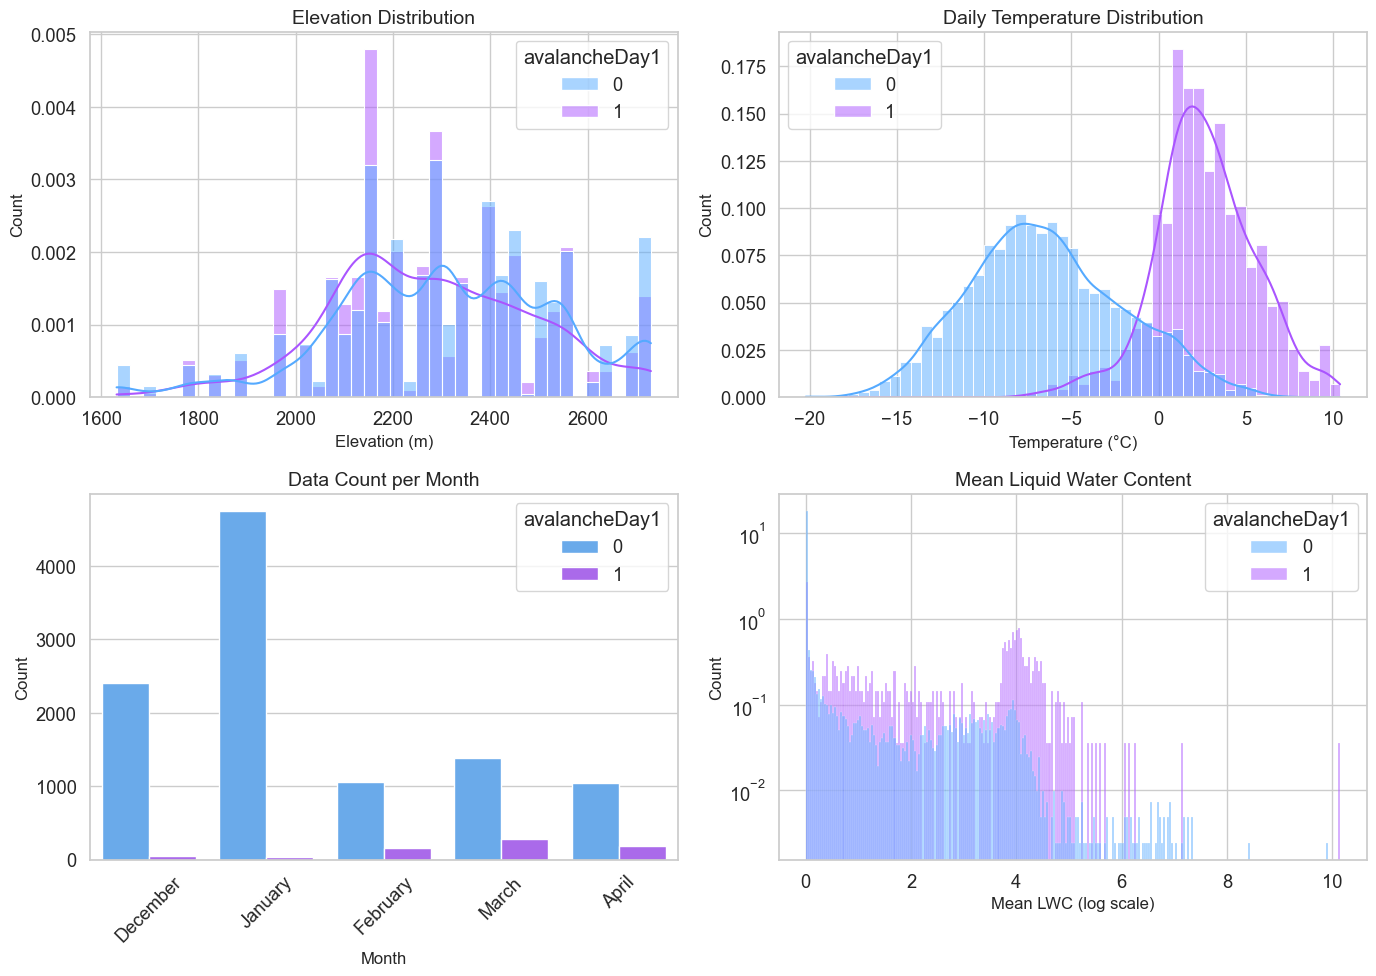

In [238]:

# Set a pretty seaborn style
sns.set(style='whitegrid', font_scale=1.2)

# Prepare month order
selected_months = ['December', 'January', 'February', 'March', 'April']

# Create subplots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax = ax.flat

# 1st plot: Elevation Histogram
sns.histplot(
    data=df,
    x='elevation',
    ax=ax[0],
    kde=True,
 palette='cool',

    hue='avalancheDay1',
    stat='density',   # <-- THIS normalizes it!
    common_norm=False # <-- THIS normalizes *separately* for each hue
)
ax[0].set_title('Elevation Distribution', fontsize=14)
ax[0].set_xlabel('Elevation (m)', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)

# 2nd plot: Temperature Histogram
sns.histplot(data=df, x='TA_daily', ax=ax[1], kde=True, hue='avalancheDay1',  stat='density',  common_norm=False, palette='cool')
ax[1].set_title('Daily Temperature Distribution', fontsize=14)
ax[1].set_xlabel('Temperature (°C)', fontsize=12)
ax[1].set_ylabel('Count', fontsize=12)

# 3rd plot: Month Countplot
sns.countplot(data=df, x='month', ax=ax[2], order=selected_months, palette='cool', hue='avalancheDay1')
ax[2].set_title('Data Count per Month', fontsize=14)
ax[2].set_xlabel('Month', fontsize=12)
ax[2].set_ylabel('Count', fontsize=12)
ax[2].tick_params(axis='x', rotation=45)

# 4th plot: Mean LWC Histogram
sns.histplot(
    data=df,
    x='mean_lwc',
    ax=ax[3],
 palette='cool',
    hue='avalancheDay1',
    stat='density',
    common_norm=False
)
ax[3].set_title('Mean Liquid Water Content', fontsize=14)
ax[3].set_xlabel('Mean LWC (log scale)', fontsize=12)
ax[3].set_ylabel('Count', fontsize=12)
ax[3].set_yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()



## Dataset Prepration

In [239]:
# Drop non-numeric columns and missing data
df_numeric = df.select_dtypes(include=["number"]).dropna(axis=1).drop(columns=['year'])

# Split features and target
X = df_numeric.drop(columns=["avalancheDay1"])
y = df_numeric["avalancheDay1"]

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Model1 : Logistic regression

In [240]:
# Logistic Regression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
# Score
train_score = model.score(X_train_scaled, y_train)
test_score = model.score(X_test_scaled, y_test)
y_pred=model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for class 1


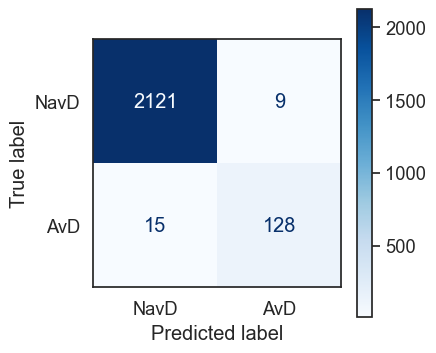

In [241]:
sns.set(style='white', font_scale=1.2)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize by row (optional, like your image)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NavD", "AvD"])
disp.plot(cmap='Blues', values_format='d', ax=ax)
plt.show()

In [242]:

print("Accuracy:", np.round(accuracy_score(y_test, y_pred), 2))
print("Precision:", np.round(precision_score(y_test, y_pred), 2))
print("Recall:", np.round(recall_score(y_test, y_pred), 2))
print("F1 Score:", np.round(f1_score(y_test, y_pred), 2))


Accuracy: 0.99
Precision: 0.93
Recall: 0.9
F1 Score: 0.91


In [243]:
vif_data = pd.DataFrame()
vif_data['Feature'] = X_train.columns
vif_data['VIF'] = [variance_inflation_factor(X_train_scaled, i) for i in range(X_train_scaled.shape[1])]
vif_data[vif_data['VIF']>10].shape

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


(38, 2)

In [251]:
scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", scores)
print("Mean CV Accuracy:", scores.mean())

Cross-Validation Accuracy Scores: [0.98789879 0.98239824 0.99394939 0.98294829 0.98734177]
Mean CV Accuracy: 0.9869072983247692


# PCA 

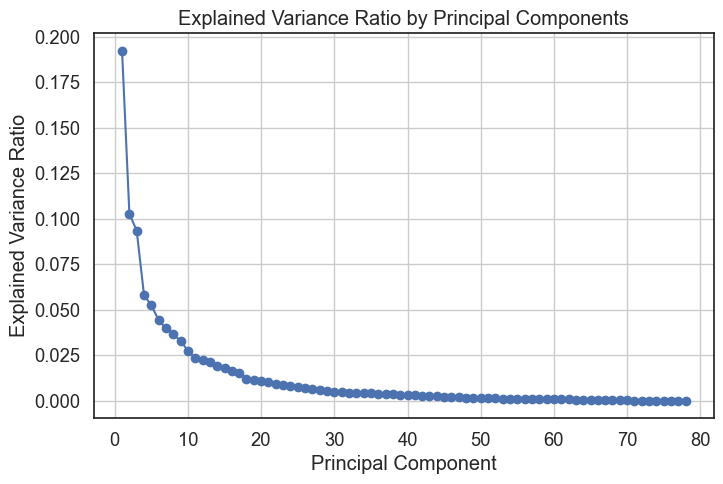

In [244]:

# Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Analyze variance
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Explained Variance Ratio by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()


In [249]:
np.cumsum(explained_variance_ratio)[[0, 1, 2, 25]]

array([0.19231147, 0.29513946, 0.3885477 , 0.90047801])

               Train Accuracy  Test Accuracy  Precision    Recall  F1 Score
1_components         0.946419       0.951606   0.708861  0.391608  0.504505
2_components         0.946309       0.952926   0.750000  0.377622  0.502326
3_components         0.946639       0.952486   0.721519  0.398601  0.513514
27_components        0.983166       0.985922   0.917293  0.853147  0.884058


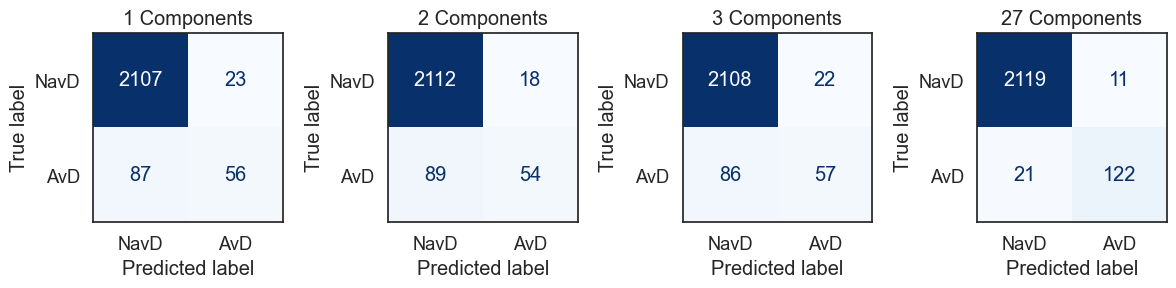

In [250]:
# Initialize dictionary to store results
results = {}

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

# Loop through different numbers of PCA components
for i, n_components in enumerate([1, 2, 3, min(27, X_train_scaled.shape[1])]):
    pipe = Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('logreg', LogisticRegression())
    ])
    pipe.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = pipe.predict(X_test_scaled)
    
    # Scores
    train_score = pipe.score(X_train_scaled, y_train)
    test_score = pipe.score(X_test_scaled, y_test)
    
    # Save metrics
    results[f'{n_components}_components'] = {
        'Train Accuracy': train_score,
        'Test Accuracy': test_score, 
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NavD", "AvD"])
    disp.plot(cmap='Blues', values_format='d', ax=ax[i], colorbar=False)
    ax[i].set_title(f'{n_components} Components')

# Adjust layout
plt.tight_layout()

# Display results
results_df = pd.DataFrame(results).T
print(results_df)


## KNN

               Best n_neighbors  Train Accuracy  Test Accuracy  Precision  \
1_components               14.0        0.952470       0.951606   0.681319   
2_components               15.0        0.958301       0.958645   0.733333   
3_components                7.0        0.966993       0.962604   0.741667   
25_components               5.0        0.985697       0.981082   0.903226   

                 Recall  F1 Score  
1_components   0.433566  0.529915  
2_components   0.538462  0.620968  
3_components   0.622378  0.676806  
25_components  0.783217  0.838951  


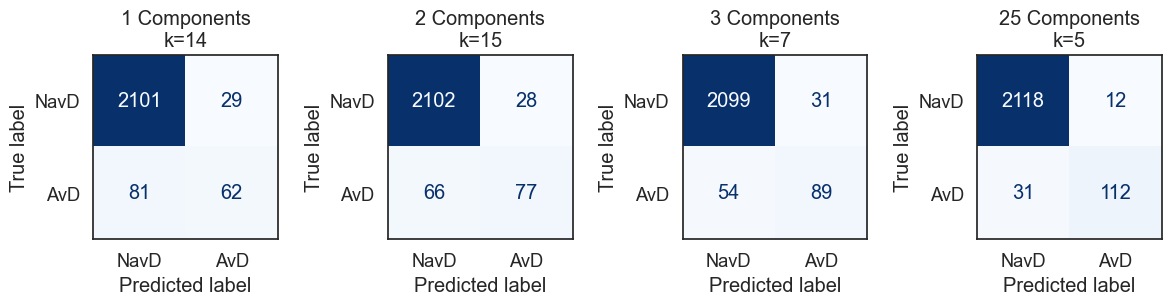

In [253]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd

# Initialize dictionary to store results
results = {}

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

# Loop through different numbers of PCA components
for i, n_components in enumerate([1, 2, 3, min(25, X_train_scaled.shape[1])]):
    
    # Define pipeline
    pipe = Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('knn', KNeighborsClassifier())
    ])
    
    # Define parameters to tune
    param_grid = {
        'knn__n_neighbors': list(range(1, 16))  # Trying n_neighbors from 1 to 15
    }
    
    # Grid Search
    grid = GridSearchCV(pipe, param_grid, cv=5)
    grid.fit(X_train_scaled, y_train)
    
    # Best model
    best_pipe = grid.best_estimator_
    best_n_neighbors = grid.best_params_['knn__n_neighbors']
    
    # Predictions
    y_pred = best_pipe.predict(X_test_scaled)
    
    # Scores
    train_score = best_pipe.score(X_train_scaled, y_train)
    test_score = best_pipe.score(X_test_scaled, y_test)
    
    # Save metrics
    results[f'{n_components}_components'] = {
        'Best n_neighbors': best_n_neighbors,
        'Train Accuracy': train_score,
        'Test Accuracy': test_score, 
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NavD", "AvD"])
    disp.plot(cmap='Blues', values_format='d', ax=ax[i], colorbar=False)
    ax[i].set_title(f'{n_components} Components\nk={best_n_neighbors}')

# Adjust layout
plt.tight_layout()

# Display results
results_df = pd.DataFrame(results).T
print(results_df)


# SVM 

KeyboardInterrupt: 

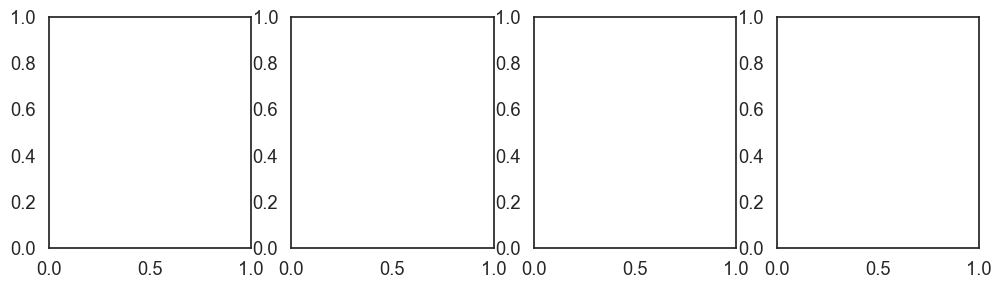

In [255]:
# Initialize dictionary to store results
results = {}

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

# Loop through different numbers of PCA components
for i, n_components in enumerate([1, 2, 3, min(25, X_train_scaled.shape[1])]):
    
    # Define pipeline
    pipe = Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('svm', SVC())
    ])
    
    # Define parameters to tune
    param_grid = {
        'svm__C': [0.1, 1, 10, 100],  # regularization strength
        'svm__kernel': ['linear', 'rbf']  # different kernel types
    }
    
    # Grid Search
    grid = GridSearchCV(pipe, param_grid, cv=5)
    grid.fit(X_train_scaled, y_train)
    
    # Best model
    best_pipe = grid.best_estimator_
    best_params = grid.best_params_
    
    # Predictions
    y_pred = best_pipe.predict(X_test_scaled)
    
    # Scores
    train_score = best_pipe.score(X_train_scaled, y_train)
    test_score = best_pipe.score(X_test_scaled, y_test)
    
    # Save metrics
    results[f'{n_components}_components'] = {
        'Best C': best_params['svm__C'],
        'Best Kernel': best_params['svm__kernel'],
        'Train Accuracy': train_score,
        'Test Accuracy': test_score, 
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NavD", "AvD"])
    disp.plot(cmap='Blues', values_format='d', ax=ax[i], colorbar=False)
    ax[i].set_title(f'{n_components} Components\nC={best_params["svm__C"]}\n{best_params["svm__kernel"]} kernel')

# Adjust layout
plt.tight_layout()

# Display results
results_df = pd.DataFrame(results).T
print(results_df)